In [4]:
import torch
from datasets import Dataset, DatasetDict, IterableDataset, load_dataset,load_from_disk
import hashlib
import os
import tqdm
# 示例文件路径
file_path = "/mnt/file2/changye/dataset/Align-Anything-preference_interp/Align-Anything-preference_coocur.pt"

os.environ['HF_DATASETS_CACHE']='/mnt/file2/changye/tmp'
# 读取 .pt 文件
data = torch.load(file_path)

dataset_path="/mnt/file2/changye/dataset/Align-Anything_preference"
train_dataset = load_dataset(
            dataset_path,
            split="train",
            trust_remote_code=True,
        )


/home/changye/miniconda3/envs/sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2444810/461370850.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett

In [5]:
print(train_dataset)
print(train_dataset["overall_response"][0])

Dataset({
    features: ['question', 'image', 'response_1', 'response_2', 'res_1_from', 'res_2_from', 'p_response', 'prompt_following_rate_1', 'prompt_following_rate_2', 'p_rationale_1', 'p_rationale_2', 'o_response', 'objective_rules_rate_1', 'objective_rules_rate_2', 'o_rationale_1', 'o_rationale_2', 'c_response', 'clarity_rate_1', 'clarity_rate_2', 'c_rationale_1', 'c_rationale_2', 'i_response', 'information_richness_rate_1', 'information_richness_rate_2', 'i_rationale_1', 'i_rationale_2', 's_response', 'safety_rate_1', 'safety_rate_2', 's_rationale_1', 's_rationale_2', 'text_critique_1', 'text_critique_2', 'overall_response', 'overall_textfeedback'],
    num_rows: 38401
})
2


In [6]:
# 定义需要保留的列
columns_to_keep = ["question", "image", "response_1", "response_2", "overall_response"]

# 使用 remove_columns 移除不需要的列
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in columns_to_keep])

# 打印结果
print(train_dataset)


Dataset({
    features: ['question', 'image', 'response_1', 'response_2', 'overall_response'],
    num_rows: 38401
})


In [7]:

data_list=[]
for data_l in data:
    keys=list(data_l.keys())
    for key in keys:
        data_list.append((key,data_l[key]))


In [8]:
print(len(data_list))
print(data_list[0]) 

37990
('bab65107176a96aab5069c8cfa912fb55fc3c31d24cce541f34a057c1b80b44c', [40961, 3586, 17411, 2053, 27655, 6664, 9225, 50697, 21001, 24588, 34318, 37906, 48150, 54807, 24088, 36378, 28699, 38940, 41502, 51742, 60450, 27171, 50726, 22058, 13870, 34354, 43058, 8246, 60982, 42040, 57401, 43065, 64054, 32310, 11840, 63552, 29253, 58950, 55366, 11849, 15433, 20044, 57421, 59982, 27728, 54864, 38998, 3671, 19032, 17497, 62553, 63065, 51296, 55393, 56418, 21092, 51305, 9321, 50282, 33901, 26222, 15983, 29808, 53362, 115, 63093, 1142, 9334, 4727, 39541, 12410, 48765, 49278, 37502, 6787, 22661, 16519, 42120, 51848, 43657, 61577, 46217, 38027, 20112, 63632, 25751, 18073, 5275, 2205, 46749, 43679, 13471, 47263, 54435, 59044, 36517, 60070, 15525, 43689, 19625, 52394, 33965, 13489, 35508, 4276, 58038, 37044, 38583, 17593, 63669, 42691, 8900, 51400, 56012, 59086, 43217, 47825, 15058, 43732, 23763, 9942, 48343, 12504, 14553, 60126, 37598, 50401, 17122, 3810, 44770, 59109, 21218, 37607, 14052, 58601

In [9]:
def generate_text_hash(text: str) -> str:
    """
    Generate a unique identifier for the given text using SHA-256.

    Args:
        text (str): Input text.

    Returns:
        str: Unique hash for the text.
    """
    hash_object = hashlib.sha256(text.encode('utf-8'))
    return hash_object.hexdigest()

In [26]:
dataset_dict = {}
for j, item in tqdm.tqdm(enumerate(train_dataset), desc="Processing data_list", unit="item"):
    key = generate_text_hash(item['question']+item['response_1']+item['response_2'])
    if key not in dataset_dict:
        dataset_dict[key] = []
    dataset_dict[key].append(j)  # 记录每个idx对应的所有匹配位置

# 2. 生成 formatted_dataset，确保按照顺序匹配
formatted_dataset = []
index_set = set()  # 用来记录已经匹配过的 train_dataset 索引

# 使用 tqdm 显示进度条
for i in tqdm.tqdm(range(len(data_list)), desc="Processing data_list", unit="item"):
    key_datalist, value_datalist = data_list[i]
    
    # 查找是否存在匹配的key
    if key_datalist in dataset_dict:
        # 遍历匹配的索引
        for j in dataset_dict[key_datalist]:
            if j not in index_set:  # 如果该项未匹配过
                # 如果匹配，则将 value 从 data_list 加到 train_dataset 项中
                new_item = train_dataset[j].copy()  # 拷贝 train_dataset 项
                new_item["coocur"] = value_datalist
                formatted_dataset.append(new_item)
                
                # 将已匹配的索引添加到 index_set
                index_set.add(j)
                break  # 找到一个匹配就跳出内层循环，继续下一个 data_list 的元素


Processing data_list: 38401item [07:50, 81.53item/s] 
Processing data_list: 100%|██████████| 37990/37990 [08:27<00:00, 74.92item/s] 


In [27]:
print(len(formatted_dataset))
print(formatted_dataset[0])

37990
{'question': 'How many people are carrying musical instrument cases in the image?', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x917 at 0x7FE3303F0E50>, 'response_1': 'There is a group of three men walking down the street, each one carrying their own musical instrument case.', 'response_2': "There appear to be three individuals holding guitar or bass cases.  The man on the left is likely carrying a large case for an upright bass, while the other two men carry what appears to be electric guitars.\n\nTherefore, there are at least three people carrying musical instruments in this photo. It's possible that one of them may also have another item inside their bag as well; however, without further information it cannot be determined if they do so with certainty.", 'overall_response': 2, 'coocur': [40961, 3586, 17411, 2053, 27655, 6664, 9225, 50697, 21001, 24588, 34318, 37906, 48150, 54807, 24088, 36378, 28699, 38940, 41502, 51742, 60450, 27171, 50726, 22058, 13870,

In [28]:
# 定义文件路径
cosi_file_path = "/mnt/file2/changye/dataset/Align-Anything-preference_interp/AA_preference_cosi_weight/cosi_feature_list.txt"  # 将此替换为你的文件路径

# 读取文件并转换为字典
osi_dict = {}
with open(cosi_file_path, "r") as file:
    for line in file:
        key, value = line.strip().split(",")  # 按逗号分割每行
        osi_dict[int(key)] = float(value)    # 将 key 转为 int, value 转为 float

# 输出结果
print(osi_dict)

{8: 0.1803319673417412, 27: 0.07624877010851419, 30: 0.16079967690265198, 37: 0.2320393756287136, 41: 0.1296554306894705, 77: 0.12057411458845058, 99: 0.16689908665348924, 104: 0.10100131130325447, 166: 0.13831489037555803, 180: 0.187928346047327, 202: 0.10203617812351685, 203: 0.17962658552532634, 219: 0.16600072836307597, 228: 0.12182254640492976, 240: 0.1280655098561415, 248: 0.23130211120002053, 314: 0.16100498079438566, 333: 0.15887215552555173, 340: 0.22784604186650345, 342: 0.177867149395456, 354: 0.18433397573445312, 365: 0.14000439074037976, 366: 0.2260172921269944, 392: 0.163625917906823, 395: 0.10237602041570819, 397: 0.23354237145256695, 404: 0.13226195000342453, 414: 0.18576910052133258, 422: 0.13475143882115018, 423: 0.20623218389319564, 429: 0.19252640342150534, 451: 0.21772166621892555, 489: 0.13929760982780956, 536: 0.21348896084067076, 572: 0.17933064329183576, 576: 0.1358896746449612, 583: 0.16816028095176644, 584: 0.22922598898599705, 632: 0.11146650801107556, 663: 

In [30]:
set_cosi_key=set(osi_dict.keys())
cosi_coocur_data={}
for f_data in tqdm.tqdm(formatted_dataset):
    score=0
    for value in f_data['coocur']:
        if value in set_cosi_key:
            score+=osi_dict[value]
    f_data["Cooccur_score"]=score

  0%|          | 0/37990 [00:00<?, ?it/s]

100%|██████████| 37990/37990 [00:00<00:00, 45684.46it/s]


In [31]:
print(formatted_dataset[-1])

{'question': 'What types of trees can you see in the image?', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1200x936 at 0x7FE0E038F4F0>, 'response_1': "There are several different kinds of trees visible, including deciduous and evergreen. The bare branches on some of them indicate that they may be transitioning from summer to fall or winter seasons. There also appears to be a large pile of brush at the bottom center of this photo which could have been cut down recently.\n\nThe most prominent tree is likely an oak because it has leaves with lobes like those found on white oaks (Quercus alba) but without any acorns present. Another possibility for these trees might be birch since their bark resembles paper-like texture seen here; however, there aren't enough details provided yet so we cannot say definitively what kind exactly they represent just based off appearance alone - only further investigation would give us more insight into identifying species accurately among oth

In [14]:
dataset = Dataset.from_list(formatted_dataset)
dataset.save_to_disk("/data/changye/data/Align-Anything-cosi-full")

Saving the dataset (0/13 shards):   0%|          | 0/99160 [00:00<?, ? examples/s]

In [13]:
for item in formatted_dataset:
    item["l0"]=float(item["l0"])

In [32]:
# 1. 根据 l0 字段从大到小对数据集排序
formatted_dataset_sorted = sorted(formatted_dataset, key=lambda x: x["Cooccur_score"], reverse=True)

In [33]:
print(formatted_dataset_sorted[0])
print(formatted_dataset_sorted[-1])

{'question': "Why do you think the College Board is interested in a student's ability to manipulate language in their analysis?", 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=448x336 at 0x7FE1A02B8CD0>, 'response_1': "The College Board might be interested in a student's ability to manipulate language in their analysis because it demonstrates critical thinking, reasoning skills, and effective communication. In academic settings like college or university, students are expected to engage with complex ideas, analyze information from various sources, and present arguments based on evidence. Being able to effectively communicate these insights through writing helps them convey their thoughts clearly while also showcasing their understanding of the subject matter. This skill can significantly contribute to success not only during undergraduate studies but also later in life when applying for graduate programs, job opportunities, or other professional pursuits that require st

In [34]:


# 2. 将数据集分成四个分位
num_samples = len(formatted_dataset_sorted)
q1 = int(num_samples * 0.25)
q2 = int(num_samples * 0.5)
q3 = int(num_samples * 0.75)

# 将数据集切分为四个分位
split_datasets = {
    "q0_25": formatted_dataset_sorted[:q1],
    "q25_50": formatted_dataset_sorted[q1:q2],
    "q50_75": formatted_dataset_sorted[q2:q3],
    "q75_100": formatted_dataset_sorted[q3:]
}

# 3. 转换为 HuggingFace Dataset 格式并保存，显示进度条
hf_datasets = {}
for split_name, split_data in tqdm.tqdm(split_datasets.items(), desc="Processing splits", unit="split"):
     # 初始化一个空字典用于存储格式化数据
    formatted_data = {}
    
    # 添加进度条，逐列转换数据
    for key in tqdm.tqdm(split_data[0].keys(), desc=f"Formatting {split_name}", unit="column",position=1):
        formatted_data[key] = [d[key] for d in split_data]
    
    # 将格式化的数据创建为 HuggingFace 数据集
    hf_datasets[split_name] = Dataset.from_dict(formatted_data)

    # 保存每个分位数据集到磁盘
    hf_datasets[split_name].save_to_disk(f"./{split_name}_dataset")

# 输出一下分割的数据集
for split_name, dataset in hf_datasets.items():
    print(f"{split_name} dataset:")
    print(dataset)

Processing splits: 100%|██████████| 4/4 [1:14:19<00:00, 1114.81s/split]

q0_25 dataset:
Dataset({
    features: ['question', 'image', 'response_1', 'response_2', 'overall_response', 'coocur', 'Cooccur_score'],
    num_rows: 9497
})
q25_50 dataset:
Dataset({
    features: ['question', 'image', 'response_1', 'response_2', 'overall_response', 'coocur', 'Cooccur_score'],
    num_rows: 9498
})
q50_75 dataset:
Dataset({
    features: ['question', 'image', 'response_1', 'response_2', 'overall_response', 'coocur', 'Cooccur_score'],
    num_rows: 9497
})
q75_100 dataset:
Dataset({
    features: ['question', 'image', 'response_1', 'response_2', 'overall_response', 'coocur', 'Cooccur_score'],
    num_rows: 9498
})


In [22]:
# from datasets import load_from_disk
# formatted_dataset_sorted=load_from_disk("/mnt/file2/changye/dataset/AA_preference_coour/q0_25_dataset")
print(len(formatted_dataset_sorted[1]['coocur']))

TypeError: object of type 'int' has no len()

In [23]:
print(cosi_coocur_data['15557.jpg'])

NameError: name 'cosi_coocur_data' is not defined

/tmp/ipykernel_2444810/3049355649.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


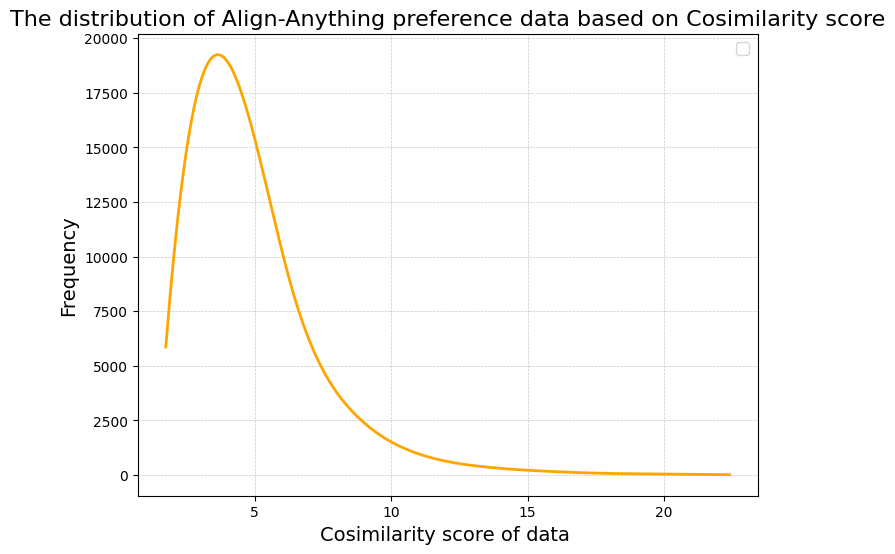

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from collections import Counter

# 假设 data_list 是一个包含数值的列表
# 例如：
# data_list = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]
# values_list = [tensor['Cooccur'].cpu().item() if tensor['Cooccur'].is_cuda else tensor['Cooccur'].item() for tensor in formatted_dataset_sorted]
values_list=[float(tensor["Cooccur_score"]) for tensor in formatted_dataset_sorted]
# 统计频率
num_bins = 10

# 生成直方图
frequencies, bin_edges = np.histogram(values_list, bins=num_bins)

# 计算每个区间的中心点（用于插值）
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 使用样条插值将直方图转换为平滑曲线
bin_centers_smooth = np.linspace(bin_centers[0], bin_centers[-1], 300)  # 插值点
frequencies_smooth = make_interp_spline(bin_centers, frequencies)(bin_centers_smooth)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_smooth, frequencies_smooth, color='orange', lw=2)


# 样式设置
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Cosimilarity score of data ', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('The distribution of Align-Anything preference data based on Cosimilarity score', fontsize=16)
plt.legend(fontsize=12)
plt.show()
